# Expectation Maximisation (EM) Algorithm
Got the codes from
https://www.ritchievink.com/blog/2019/05/24/algorithm-breakdown-expectation-maximization/

Pueh Leng Tan, 25 August 2025

In [1]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt

Text(0, 0.5, 'PDF')

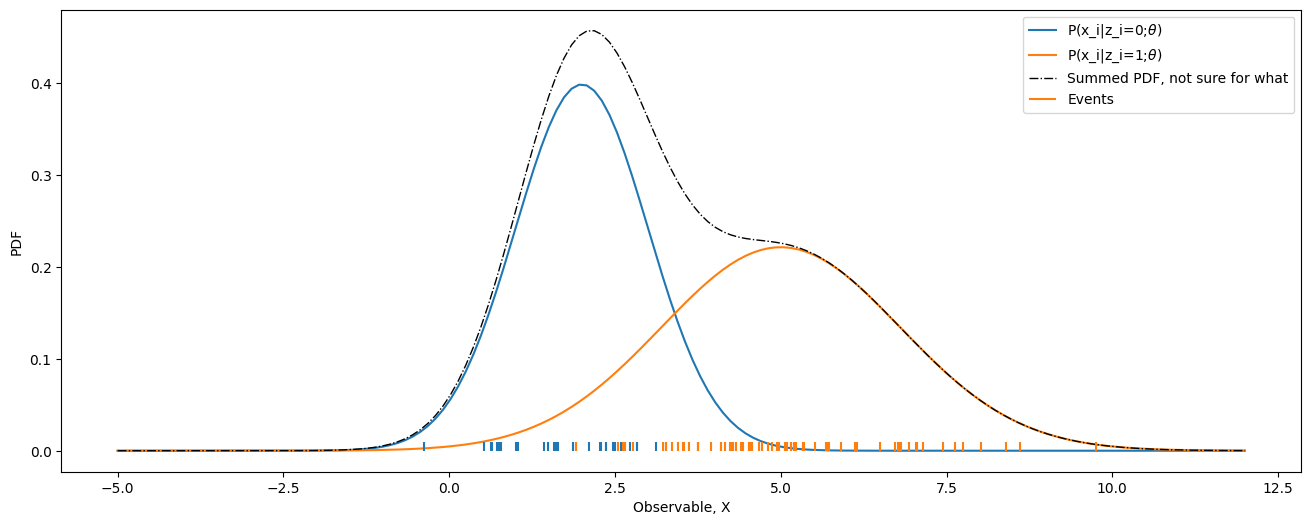

In [2]:
np.random.seed(654)
              
# Draw samples from two Gaussian w.p. z_i ~ Bernoulli(phi)
generative_m = np.array([sps.norm(2, 1), sps.norm(5, 1.8)])
z_i = sps.bernoulli(0.75).rvs(100)
x_i = np.array([g.rvs() for g in generative_m[z_i]])

# plot generated data and the latent distributions
x = np.linspace(-5, 12, 150)
plt.figure(figsize=(16, 6))
for ii in range(len(generative_m)):
    plt.plot(x, generative_m[ii].pdf(x), label=fr'P(x_i|z_i={ii};$\theta$)')
plt.plot(x, generative_m[0].pdf(x) + generative_m[1].pdf(x), lw=1, ls='-.', color='black', label='Summed PDF, not sure for what')
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z_i], label='Events')

plt.legend()
plt.xlabel('Observable, X')
plt.ylabel('PDF')

In [145]:
class EM:
    def __init__(self, k):
        self.k = k
        self.mu = None
        self.std = np.ones(k)
        self.w_ij = None
        self.phi = np.ones(k) / k
        return None

    def expectation_step(self, x):
        for z_i in range(self.k):
            self.w_ij[z_i] = sps.norm(self.mu[z_i], self.std[z_i]).pdf(x) * self.phi[z_i]
    	# normalize zo that marginalizing z would lead to p = 1
        self.w_ij /= self.w_ij.sum(0)
        return None

    def maximization_step(self, x):
        self.phi = self.w_ij.mean(1)
        self.std = ((self.w_ij * (x - self.mu[:, None])**2).sum(1) / self.w_ij.sum(1))**0.5
        self.mu = (self.w_ij * x).sum(1) / self.w_ij.sum(1)
        return None

    def termination_condition(self, last_mu, atol=1e-8):
        '''
        Returns True if termination condition has been reached.
        '''
        cond = np.nansum(last_mu-self.mu)
        return (cond<atol)
        
    def fit(self, x, max_iter=500):
        self.mu = np.random.uniform(x.min(), x.max(), size=self.k)
        self.w_ij = np.zeros((self.k, x.shape[0]))

        for _iter in range(max_iter):
            last_mu = np.ones(self.k) * np.inf
            self.expectation_step(x)
            self.maximization_step(x)
            last_mu = self.mu
            if self.termination_condition(last_mu, atol=1e-21):
                break
        print(f'max iter {max_iter} reached')
        return None

    def fit2(self, x, max_iter=500):
        self.mu = np.random.uniform(x.min(), x.max(), size=self.k)
        self.w_ij = np.zeros((self.k, x.shape[0]))

        last_mu = np.ones(self.k) * np.inf
        while ~np.all(np.isclose(self.mu, last_mu)):
            last_mu = self.mu
            self.expectation_step(x)
            self.maximization_step(x)
        return None

In [146]:
test_k = 2
model = EM(test_k) # you have to pick a k

#model.fit2(x_i, max_iter=5000)
model.fit(x_i, max_iter=5000)

max iter 5000 reached


Text(0, 0.5, 'PDF')

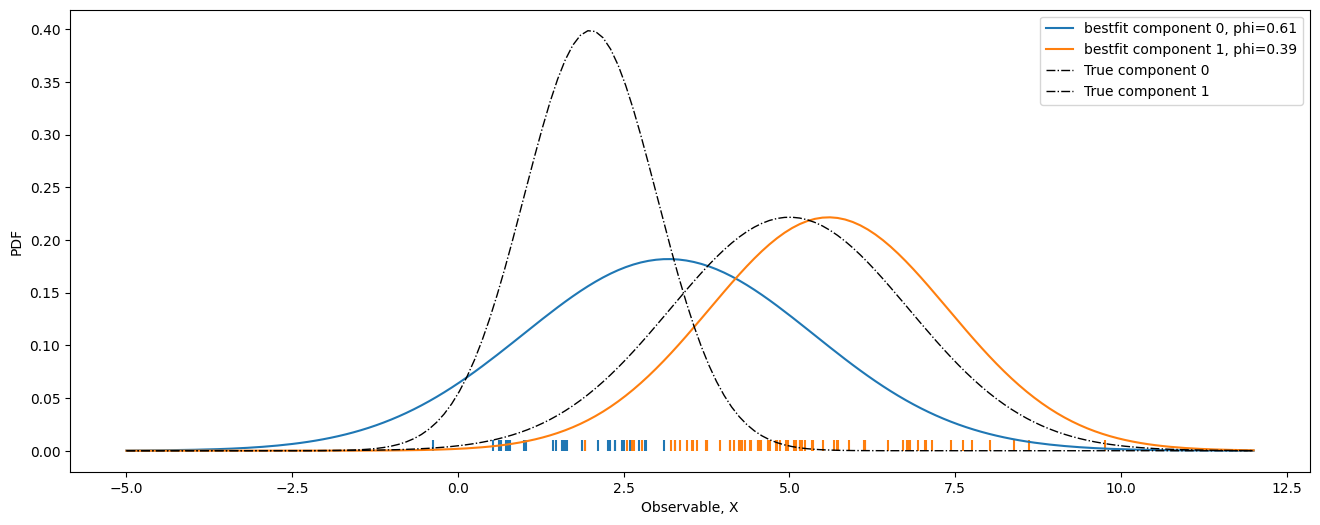

In [147]:
fitted_m = [sps.norm(mu, std) for mu, std in zip(model.mu, model.std)]

plt.figure(figsize=(16, 6))
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z_i])
for _ii, _bf in enumerate(fitted_m):
    plt.plot(x, _bf.pdf(x), label=f'bestfit component {_ii}, phi={model.phi[_ii]:.2f}')

for _ii, _truth in enumerate(generative_m):
    plt.plot(x, _truth.pdf(x), color='black', lw=1, ls='-.', label=f'True component {_ii}')

plt.legend()
plt.xlabel('Observable, X')
plt.ylabel('PDF')